%%latex
\setcounter{page}{61}
\tableofcontents 
\setcounter{section}{0}
\newpage

# Abstract
The gas sensors being investigated consists of multiple, small semiconducting grains. In the previous chapter the effect various of surface conditions onto the SMOX grain were modeled and calculated. The results show, that the charge distribution inside the grain depends on the surface potential and defect concentration of the semicondutor. When such a grain is used as a sensor, a bias voltage is applied and the resulting resistance is measured. The applied bias voltage is selected in way, that it is not interfering with the semiconductor itself. Typically the voltage is chosen to be below 1 $k_BT/e$ per grain . To numerically derive the total resistance from a specific charge distribution inside the grain, actual conduction path through the grain needs to be understood.
In this part the conduction path will be numerically derived and in a second step the dependency on the overall resistance will be derived.

# Review 
In the last notebook/chapter the semiconductor part of the SMOX grains was addressed. This included the numerical calculation the charge carrier density as as function of the conduction band bending by solving the Poisson equation for spherical grains.
The results for multiple grains are saved to file and can now be used here again without recalculating them.
Additionally a Python module was created. In this module all the functions and variables from the previous notebook are merged together and saved in file called part2.py. By importing this file, all elements will be accessible also in this notebook.
The following command will do the job:
`from part2 import *`



In [5]:
%pylab inline
from part2 import *

Populating the interactive namespace from numpy and matplotlib


# Load the results

In [25]:
storage_filename = 'numerical_sol_4_part_4_SA_50nm.h5'
#storage_filename = 'numerical_sol_4_part_4_ipc1000_55nm.h5'
calc_dF = pd.read_hdf(storage_filename, 'corr')
calc_dF.index = range(len(calc_dF))
calc_dF_all = calc_dF[calc_dF['res']<2]

Again in this notebook the final results from the previous chapter are represented. The redundancy of such a representation (especially in the printed version) may seem overexaggerated.
But when working with the interactive Jupyter notebook this choice seems legitimated, since each notebook represents a self-contained element of research. It would be optimal if all data and representation are available at place. Since the representation of the data as seen in the last chapter is of essential importance, it should be added here again.

Finding the compromise of this thesis between the printed version and the interactive notebook generates in this case some "glitches". With the strong focus to introduce the Jupyter notebook environment in this thesis the redundant representation of the figures was chosen in this case.

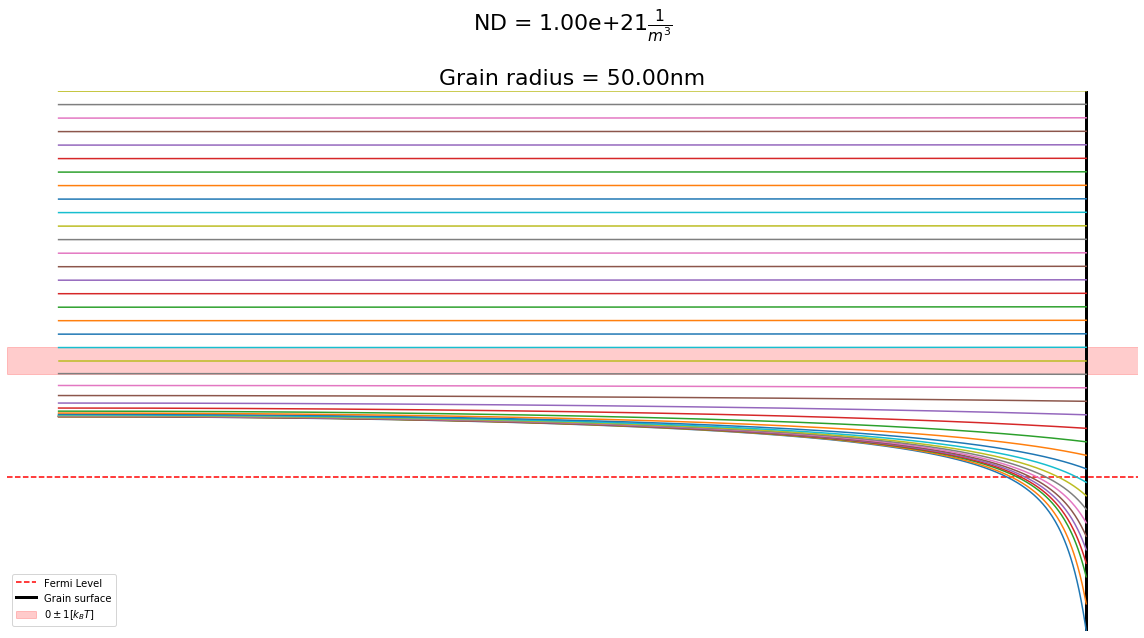

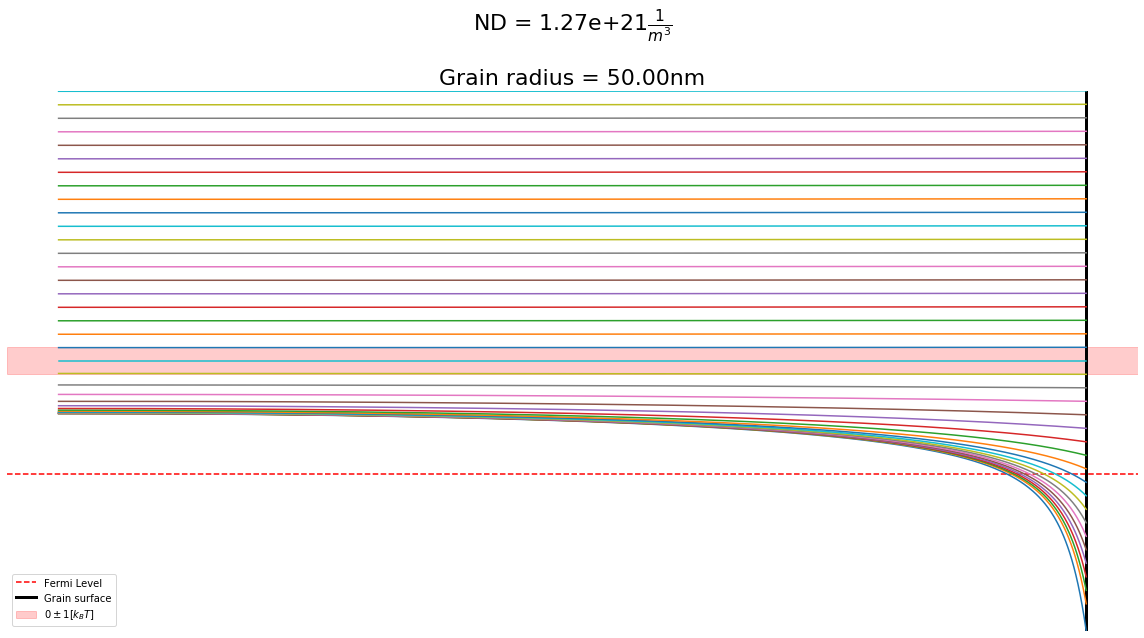

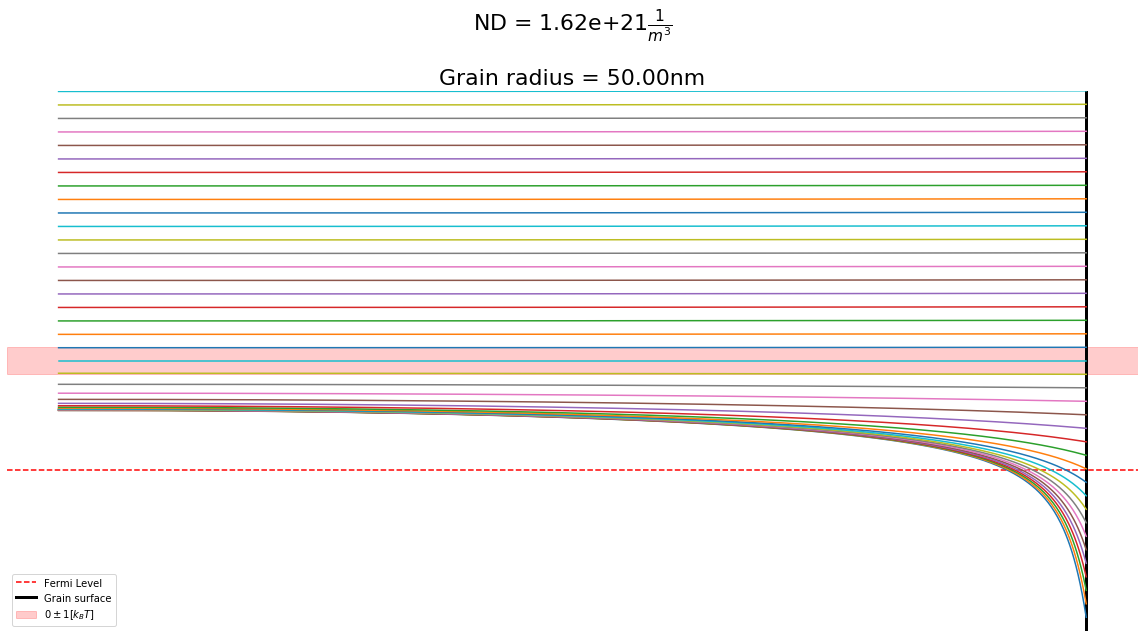

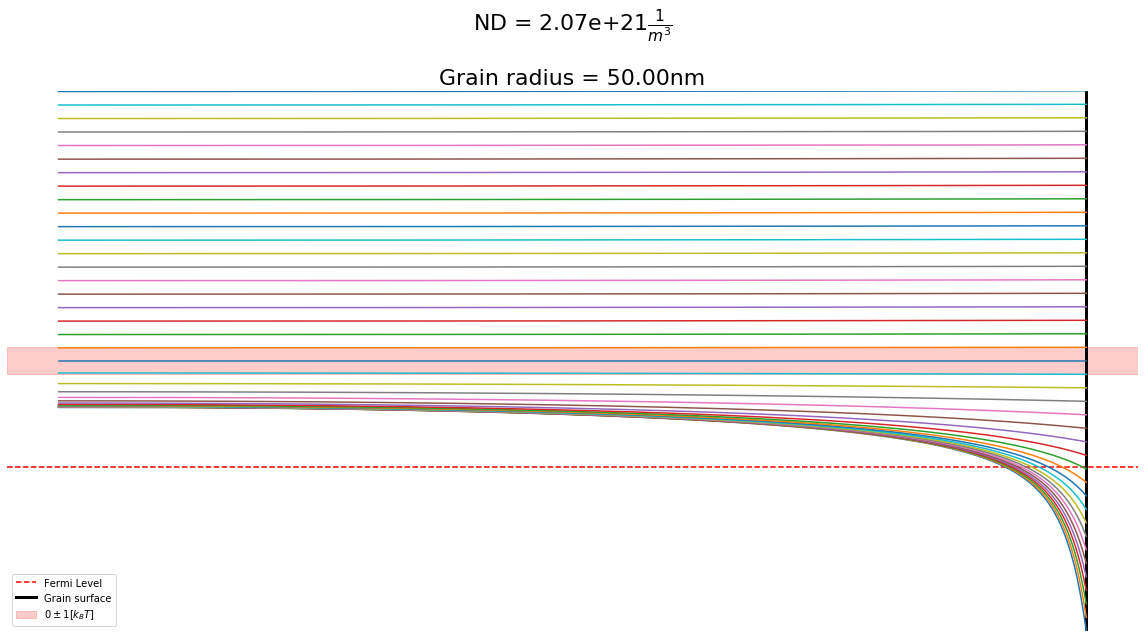

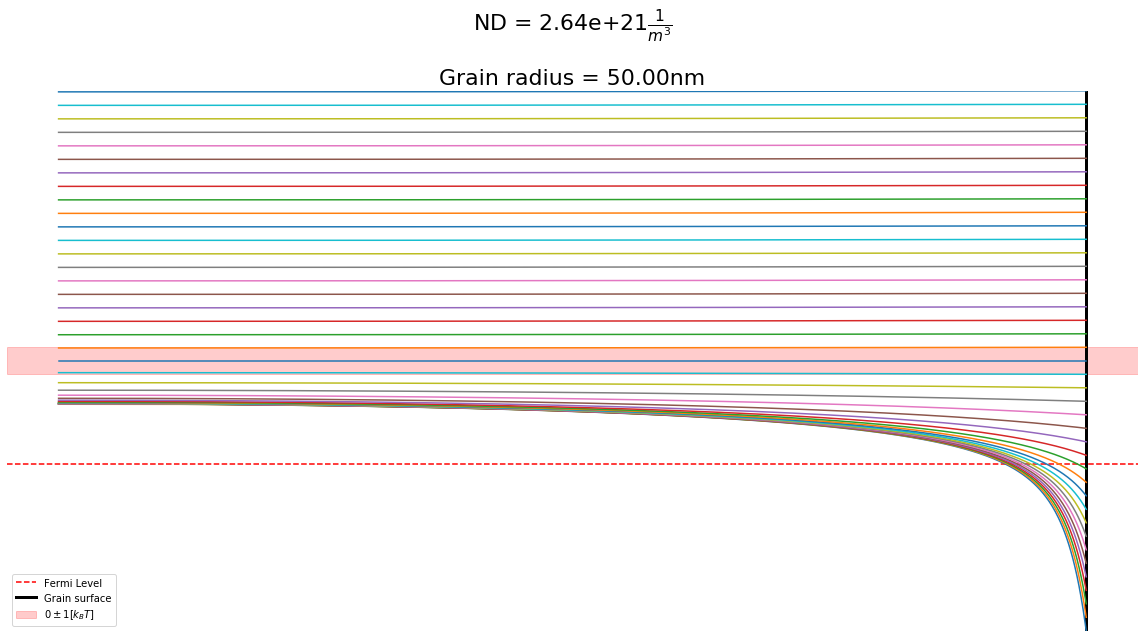

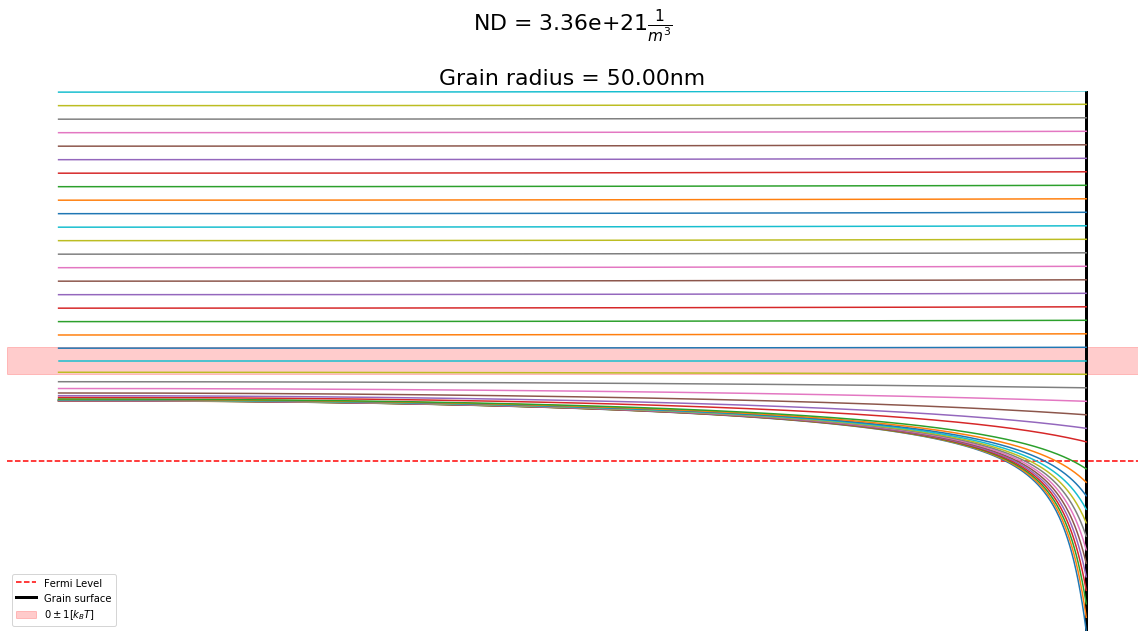

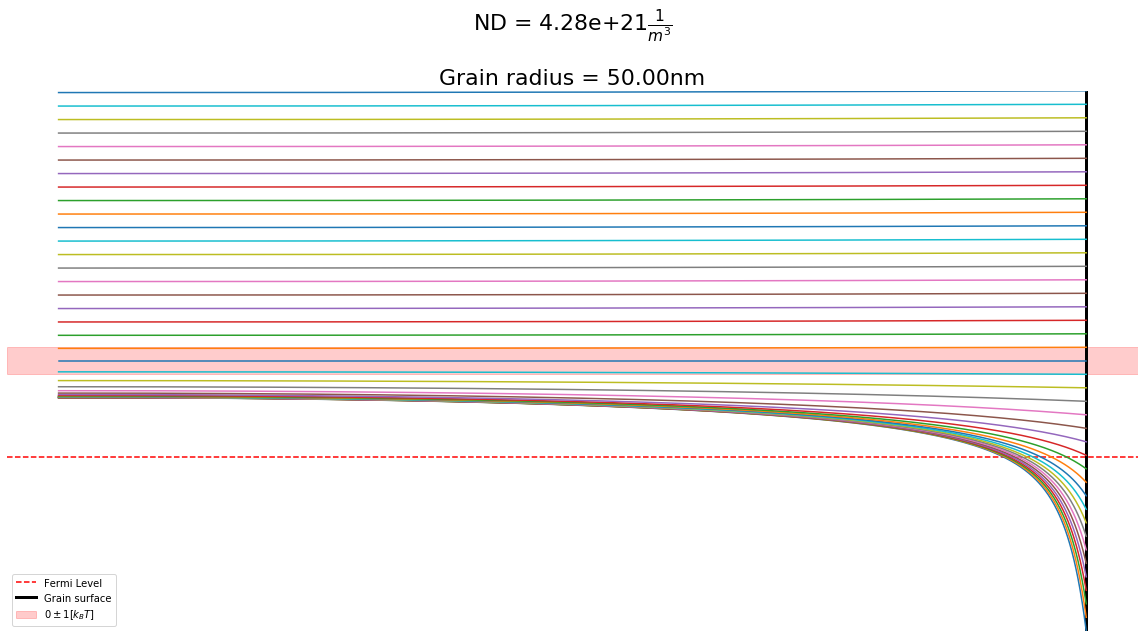

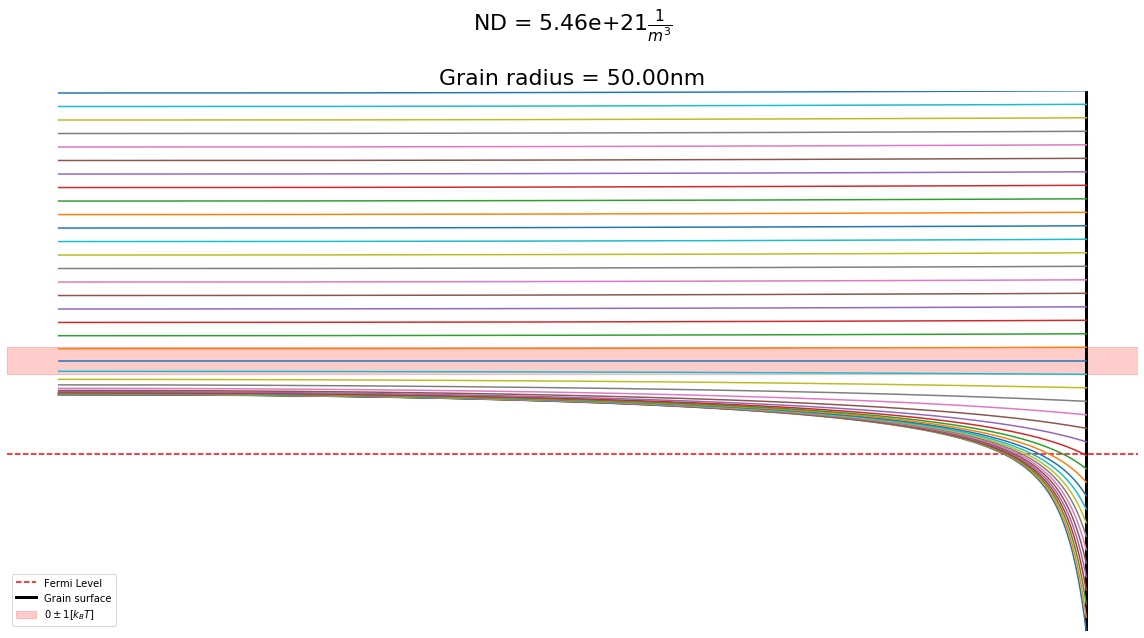

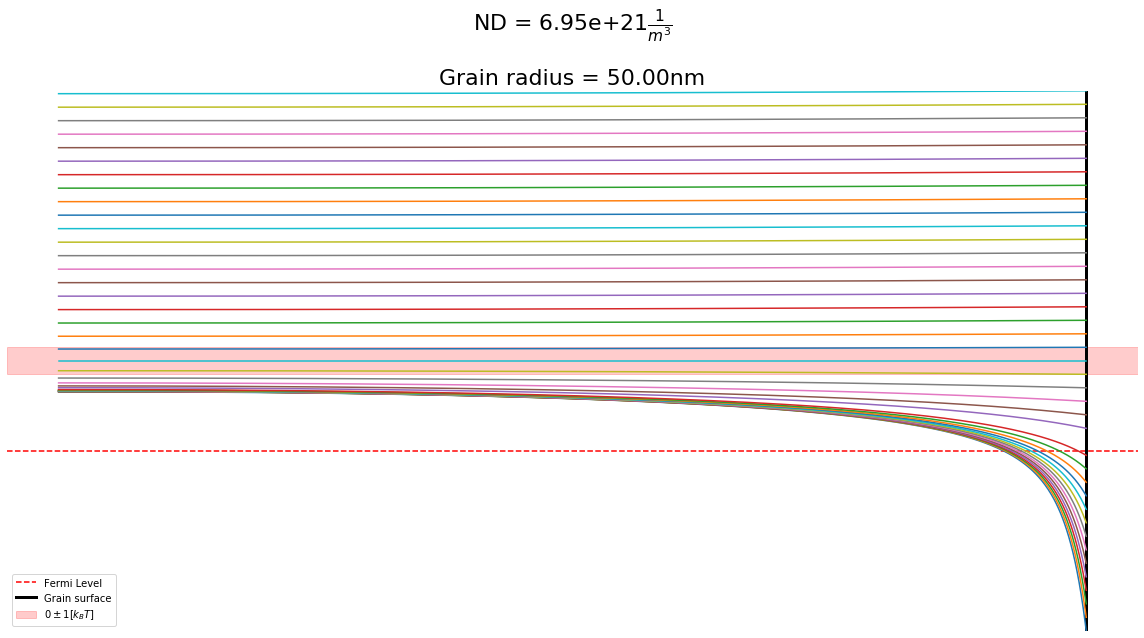

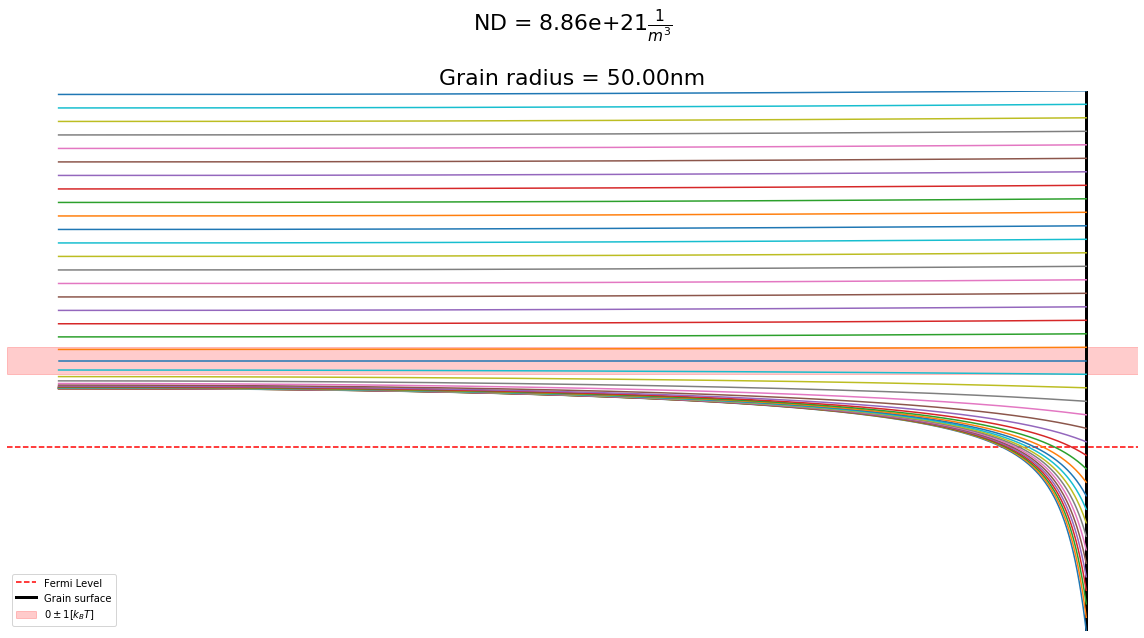

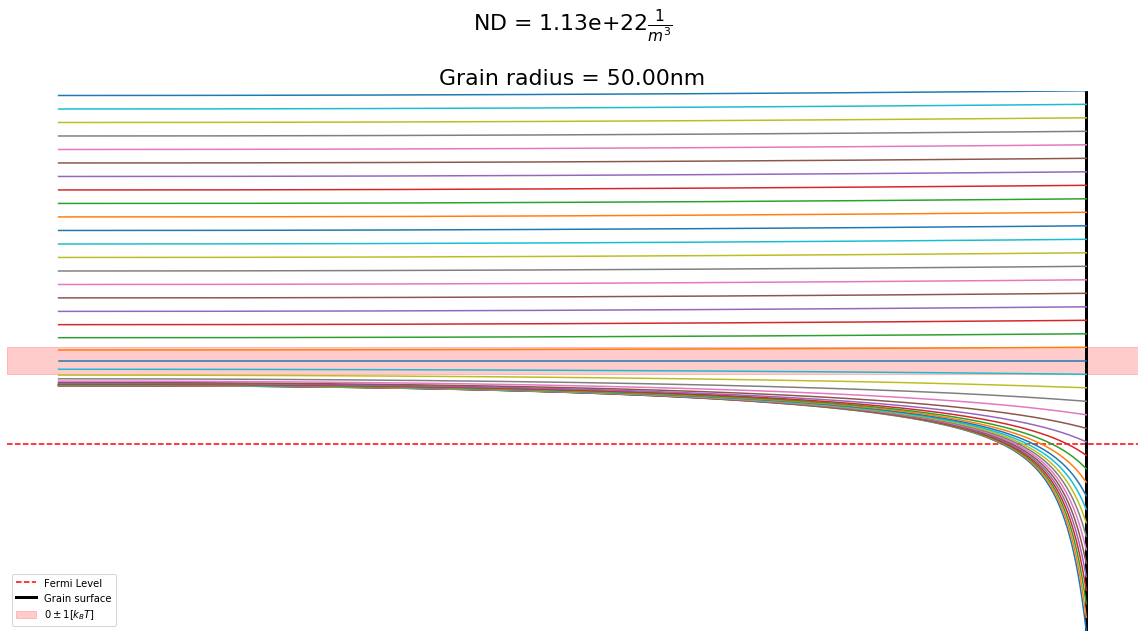

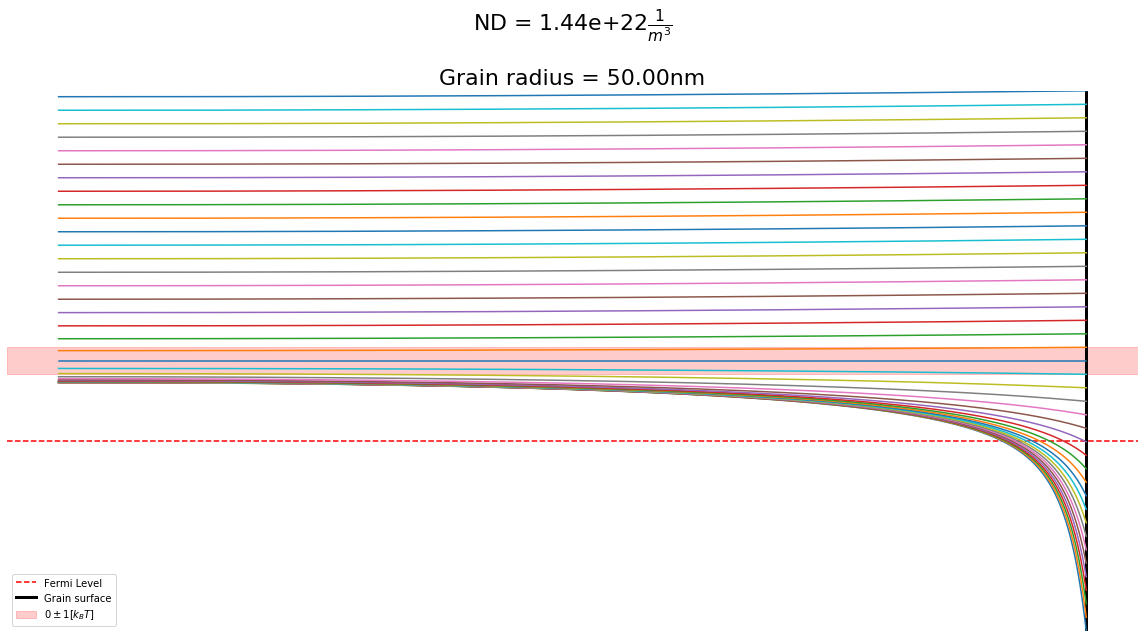

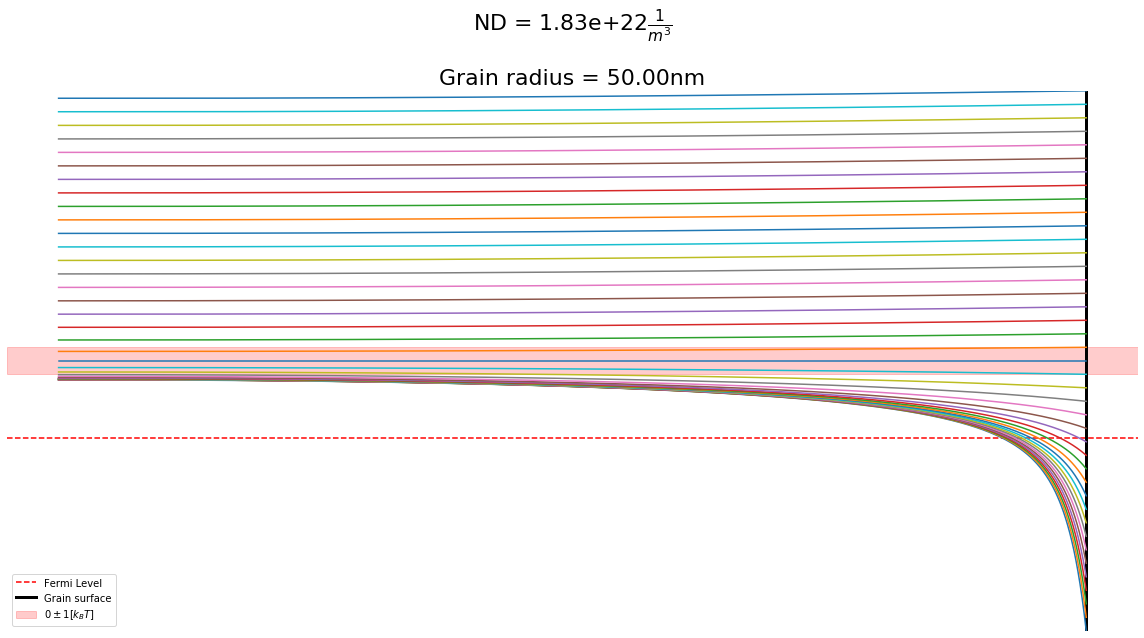

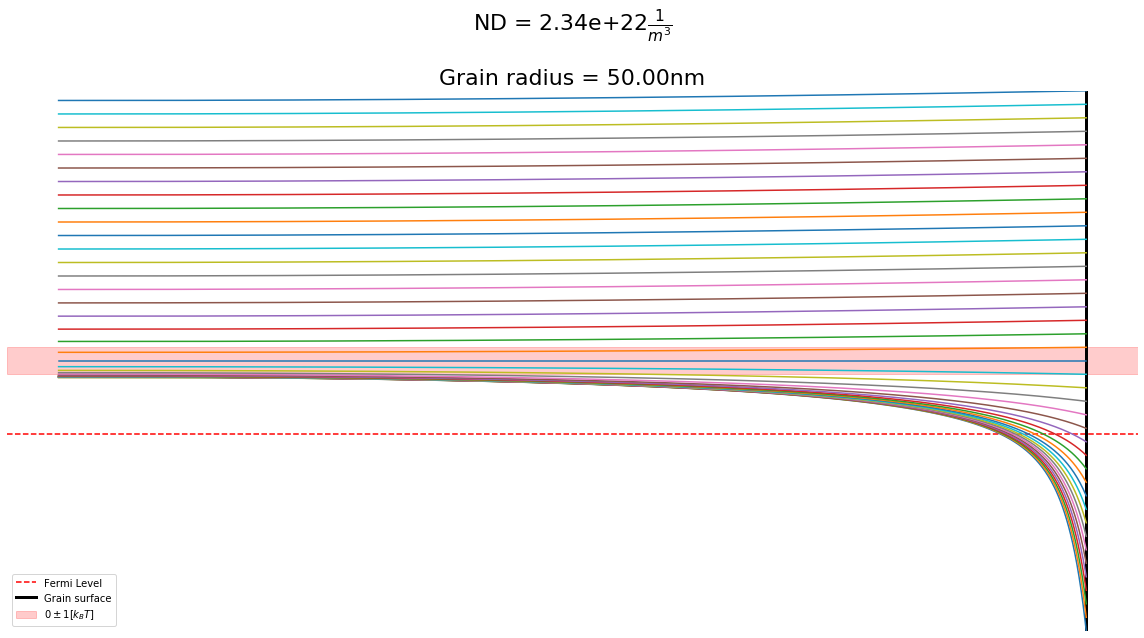

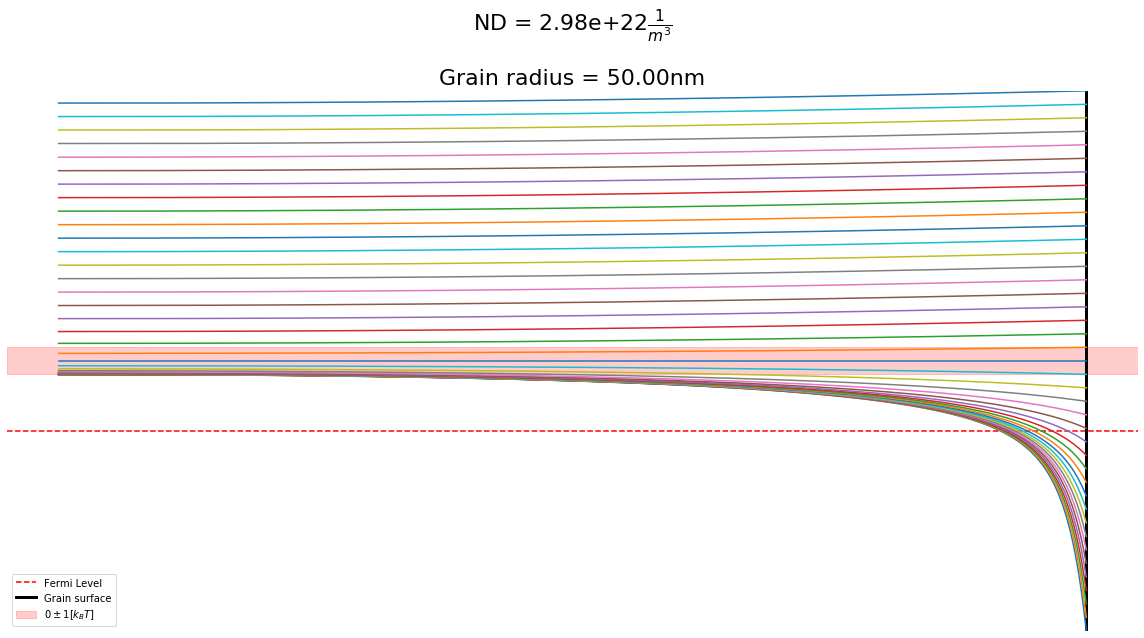

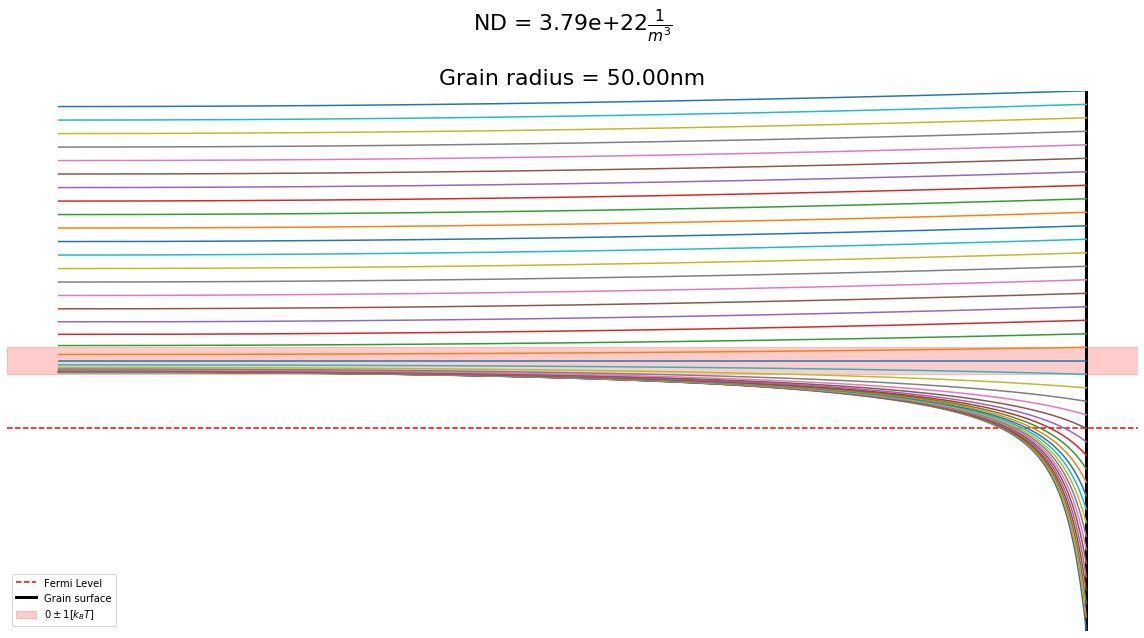

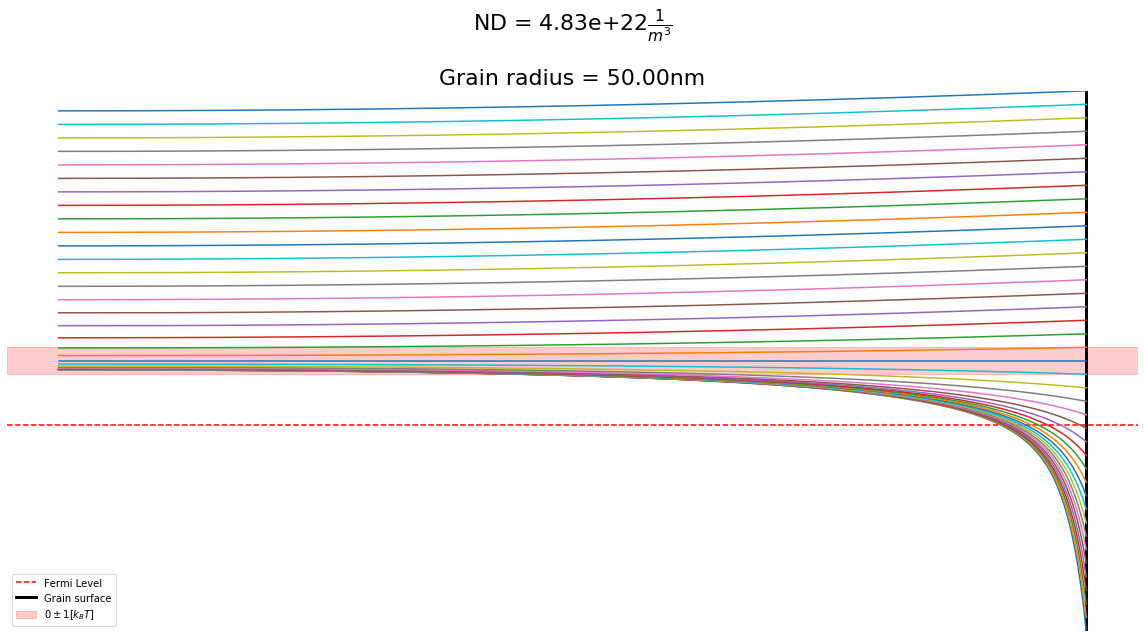

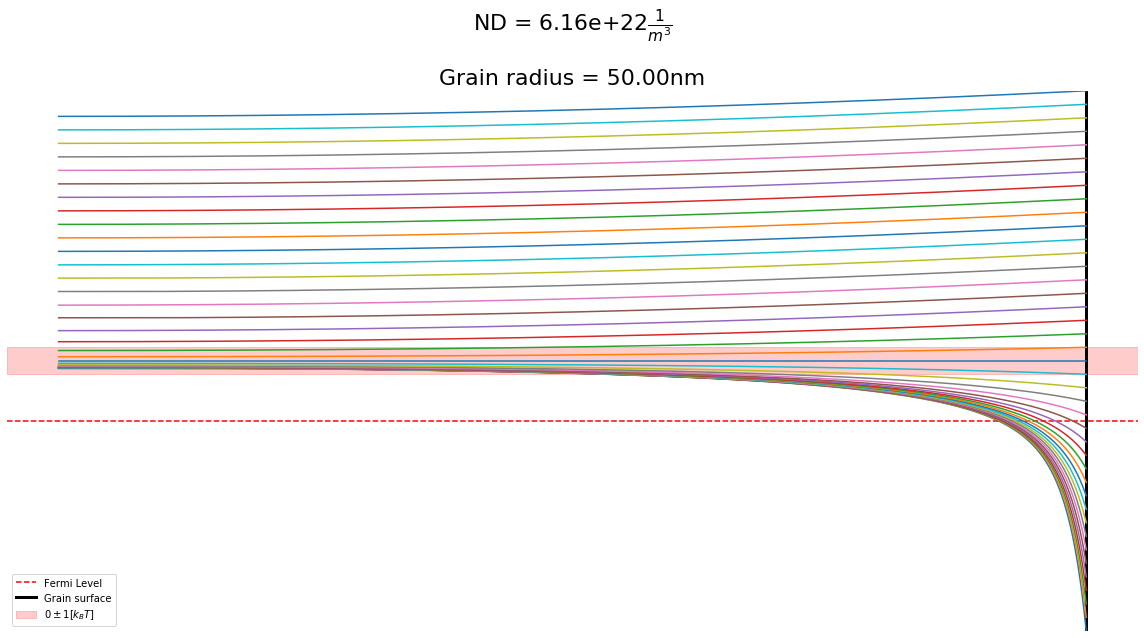

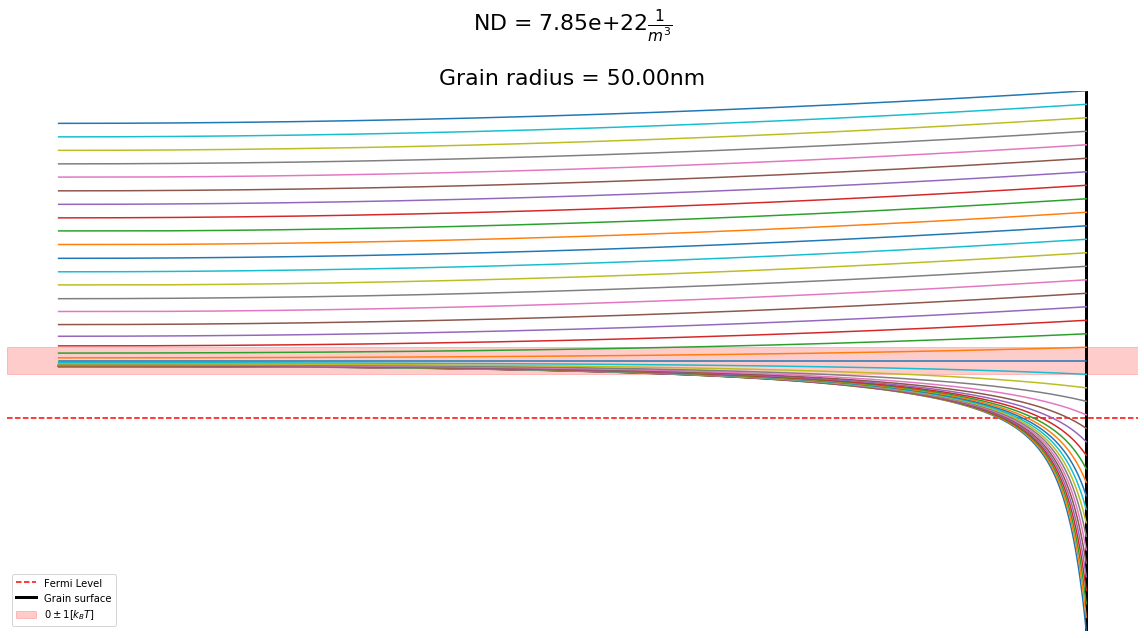

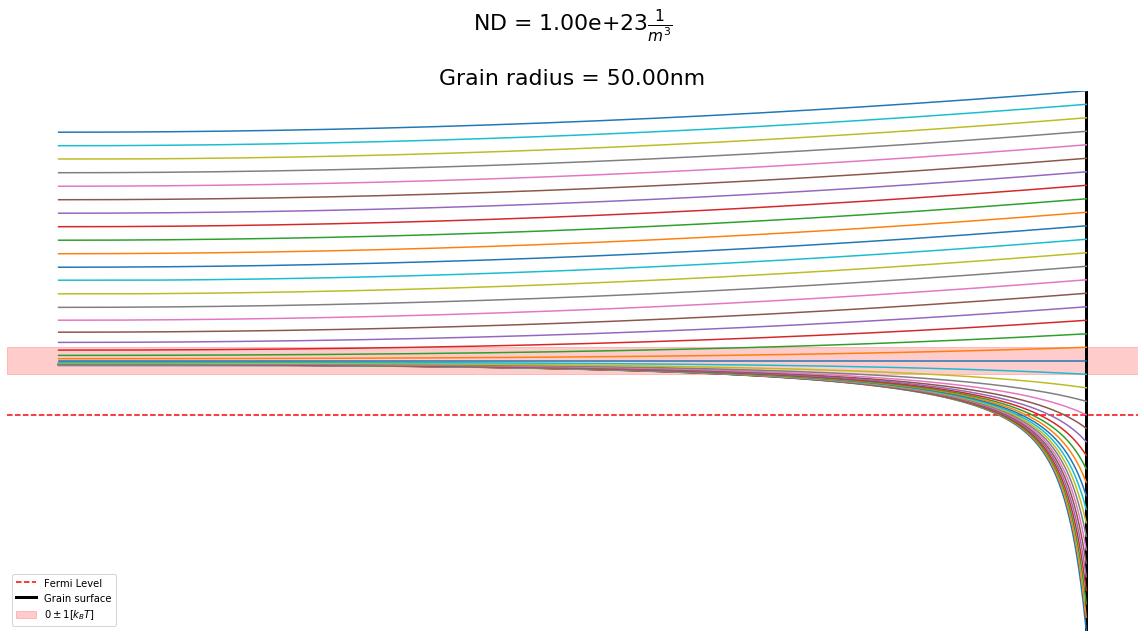

In [26]:
for ND, calc_dF in calc_dF_all.groupby('ND'):
    fig, axes= subplots(1,figsize = (16,9), sharex=True)
    
    fig.suptitle(f'ND = {ND:.2e}'+ r'$\frac{1}{m^3}$', fontsize = 22)

    
    for ax_i, (R, calc_dF_grainsize) in enumerate(calc_dF.groupby('R')):
        axe = fig.axes[ax_i]
        axe.set_ylim(-20,20)

        grain = create_grain_from_data(calc_dF_grainsize)
        

        axe.axhline(-grain.material.J_to_kT(grain.material.Diff_EF_EC),
                    linestyle='--',color='r', label='Fermi Level')
        
        axe.axvline(grain.R/grain.material.LD,
                    linewidth=3, color='k', label='Grain surface')
        
        
        
        axe.axhspan(-1,+1,color='r', alpha=0.2, label='$0\pm 1 [k_BT]$')

        for vinit, ser_temp in calc_dF_grainsize.iterrows():
            
            #discarde bad solutions from the plot
            if ser_temp['res']>5:
                continue
                
            r = ser_temp['r']
            v = ser_temp['v']
            vdot = ser_temp['v_dot']

            axe.set_title(f'Grain radius = {grain.R*1e9:.2f}nm', fontsize=22)

            axe.plot(r,v, '-', label = "")
            axe.set_ylabel('$E_C(r)$ [$k_BT$]', fontsize =22)
            axe.set_xlabel(f'Position in grain [$L_D$ = {grain.material.LD*1e9:.2f}nm]',
                           fontsize =22)
        axe.legend()
        axe.grid(b=True)
    
    fig.axes[-1].set_axis_off()
    fig.tight_layout()
    fig.subplots_adjust(top=.85)
    close()
    display(fig)
    for i in range(5):print()

This graph shows how a surface potential is shielded by the remaining ionized donors. In the case of on deletion layer ( $E_{C_{Surface}}>0 )$), the total number of charges shielding the surface potential is rather small compared to the amount of charges in an accumulation layer ( $E_{C_{Surface}}<0 )$). The result of such an asymmetry is visible in the graph. The width of the accumulation layer is by far smaller then the width of the depleted are.

# From charge distribution to resistance

## The "numerical" grain



With the previous tools and calculation the position of the conduction band inside the grain is known. With the previously defined `Material` it is possible to calculate the exact number of free charges in the conduction band. With these information it is now possible to assign each point inside the grain a certain charge density $n$. From the charge density the conductivity can be derived.
The conductivity of a semiconductor is defined by:
\begin{align}
 Conductivity  = \sigma = q*\left(n*\mu_n +p*\mu_p\right)
\end{align}
Here $q$ is the electrical charge of an electron, $n$ the density of electrons, $p$ the density of holes and $\mu_n$ the mobility of the electrons.
Focusing on the description of $SnO_2$, which is an n-type semiconductor with $n>>p$, the conductivity can be simplified to the following equation:
\begin{align}
Conductivity  = \sigma = q*n*\mu_n 
\end{align}
The relation between resistivity $\rho$ and the conductivity is given by:
\begin{align}
Resistivity  = \rho = \frac{1}{\sigma}
\end{align}

To derive from the known conductivity inside the grain the total resistance of the grain, the current path needs to be known. The current flow along the field lines inside the grain, which are equivalent to the gradient of the potential. Therefore the potential distribution inside the grain needs to be known first. To do this, the grain is represented by a numerical model. This model is created by slicing it into equal distributed cubes of the same size. Each cube will have a defined conductivity and potential. With this model a solid grain is approximated as a network for connected small resistors. For each cube $i$ with the dimension $lxlxl$, the resistance $R_i$ of the cube can be calculated as follows:

\begin{align}
R = \frac{{\rho}*l}{A} = \frac{{\rho}*l}{l*l} = \frac{{\rho}}{l}\\
\end{align}
$A$ is the area of one side of the cube.

The colored areas in the picture indicate the areas, where a bias potential will be applied to generate a virtual electrical field.

![Numerical Grain](media/pics/sliced_cube.png)

To simulate the spread of the bias potential areas inside the grain, a technique called relaxation will be used. The general idea is to guess an initial potential distribution, and then, based on the laws of physics, iteratively correct this guess. The correction is done by re-calculating each time the potential $U_0$ of one center-"cube" based on the potentials $U_i$ and conductivity $\sigma$ of the direct neighbors.

By doing this for each "cube", the potential distribution will more and more apply to the physical solution. When approaching to the solution, the overall changes in the potential of each cube will get smaller and smaller. In an ideal case it will not change anymore. In this case the potential of each cube will be just as it should be to fulfill the laws of physics.

To understand how this process can be supported by the means of modern matrix operations, I will shorty derive how $U_0$ is calculated from the surrounding $U_i$. In a second step matrix convolution will be used to solve the problem efficiently.
First we will need to combine Ohm's law and Kirchhoff's first law:
\begin{align}
R  = \frac{\Delta U}{I}\label{ohm}\tag{Ohm's law}\\
\sum_{i}I_i=0\label{kirchhoff}\tag{Kirchhoff's first law}
\end{align}

\begin{align}
\rightarrow \sum_{i}I_i=\sum_{i}\frac{\Delta U_i}{R_i} = \sum_{i}\frac{U_0-U_i}{\rho_i}\frac{A}{l}=0\\
\rightarrow \sum_{i}\frac{U_0-U_i}{\rho_i}\frac{A}{l}=0\\
\rightarrow \sum_{i}\frac{U_0}{\rho_i}=\sum_{i}\frac{U_i}{\rho_i}\\
\rightarrow U_0\sum_{i}\frac{1}{\rho_i}=\sum_{i}\frac{U_i}{\rho_i}\\
\rightarrow U_0=\frac{\sum_{i}\frac{U_i}{\rho_i}}{\sum_{i}\frac{1}{\rho_i}}\\
\rightarrow U_0=\frac{\sum_{i}{U_i*\sigma_i}}{\sum_{i}{\sigma_i}}=\frac{\sum_{i}{U_i*q*n*\mu_n }}{\sum_{i}{q*n*\mu_n }}\\=\frac{q*\mu_n}{q*\mu_n} \frac{\sum_{i}{U_i*n_i}}{\sum_{i}{n_i}}=\frac{\sum_{i}{U_i*n_i}}{\sum_{i}{n_i}}\label{u_center}\tag{$U_0$ from $U_i$}\\
\end{align}
The cube's face area $A$ and $l$ cube's length vanish from the equation since all cubes have equal sizes. Additionally $\mu_n$ is assumed to be constant inside the grain. This simplification is not necessary for the further calculation and could also be treated as a position dependent variable like $\sigma_i$. In the course of this thesis $\mu_n$ will be kept constant.

To evaluate the each $n_i$ at arbitrary points r inside the grain, one additional step is needed. Due to the nature of the numerical solution from the previous notebook we know the value of $n$ only at specific points. For values between those fix-points, an interpolation between the neighbors can be used. Again, SciPy and Python offer here also a easy to use and robust solution.
`from scipy import interpolate` adds the `interpolate` module into the kernel. The `interp1d` function of this module is described ([here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)) as follows:
>Interpolate a 1-D function.
>
>x and y are arrays of values used to approximate some function f: y = f(x). This class returns a function whose call method uses interpolation to find the value of new points.

Since the values of $n$ and $r$ exist already precalculated for specific points in the Dataframe, the following function is used to create the appropriate function for continuous values of r.

In [27]:
from scipy import interpolate

def get_interpolated_n_v(ser,grain):
    
    v = ser['v']
    r = ser['r']
    n = ser['n']
    
    r[0] = 0
    
    n_int = interpolate.interp1d(r*grain.material.LD, n, kind='cubic')
    v_int = interpolate.interp1d(r*grain.material.LD, v, kind='cubic')
    
    return n_int, v_int

As mentioned earlier, the positions of the applied virtual bias potential will only be the cubes on the far left and right, as indicated in the picture of the sliced cube. 
By arranging the bias voltage like this, the potential inside the grain will have a rotational symmetry along the axis connecting the two poles. The benefit of the resulting symmetry is that the potential inside the grain can be described by a $N\times N$ matrix, where $N$ are the number of cubes inside the grain.
Since $N\times N$ data structures are very common in modern application fields like computer vision and image recognition, many algorithm dealing with such data structures are available and optimized. In this notebook we will not reach out for potentially even faster state-of-the-art implementations like PyTorch or Tensorflow to deal with this matrix/tensor, but rather stick to the well established tool of SciPy. A nice review on  about what SciPy is can be found here: <cite data-cite="Virtanen2020">SciPy</cite> [(SciPy 1.0: fundamental algorithms for scientific computing in Python)](https://www.nature.com/articles/s41592-019-0686-2.pdf). On advantage of using "just" SciPy is, that it is easily available on most operation system and second the performance is good enough for this use case.

First we create now the data structure of the grain for further simulations. The $N\times N$ cubes will be represented by a `numpy` array. 

In [28]:
def initaliz_d_v(d_v, d_mask, v):
    d_v[:,1] = -v
    d_v[:,0] = -v
    d_v[:,-2] = +v
    d_v[:,-1] = +v
    d_v = d_v*d_mask
    return d_v


def pos_to_r(xi,yi,grain, cube_size, d):
    '''
    By passing the xi and yi indices, the grain and one array, the position (r)
    inside the grain is return
    '''
    
    cx = d.shape[0]//2+1-1 #find the center; length divided by two without rest; +1;
                            #-1 since we start counting at 0
    cy = d.shape[1]//2+1-1
   
    ri = (((xi-cx))**2+((yi-cy))**2)**0.5
    
    r = (ri*cube_size)
    return r

def r_to_pos(r, grain, cube_size, d_v):
    center = d_v.shape[0]//2
    return int(round(r/cube_size))+center
    

def create_numerical_grain_matrix( grain, ser,cube_size):
    #these functions are needed to calculate the value of n and
    #v at arbitrary positions
    n_int, v_int = get_interpolated_n_v(ser, grain)
    
    #calc. number of cubes inside the grain
    # having a uneven number ensures having a defined center layer
    nx = ny = 1+2*int(round((grain.R/cube_size)))

    #initalize the data with zeros
    
    #data for voltages =d_v
    #data for the conductivity = d_cond
    d_v = np.zeros((nx,ny))
    d_cond = np.zeros((nx,ny))
    
    #and additionally a mask 
    #for values outside the grain
    d_mask = np.zeros((nx,ny))
    
    # now the data arrays will be filled with values
    for xi in range(d_cond.shape[0]):
        for yi in range(d_cond.shape[1]):
            
            #calcualte the position iside the grain
            #from the cubes position
            r = float(pos_to_r(xi,yi,grain, cube_size, d_v))
            
            try:
                #if r is outside the grain, n_int(r) raise an error
                #and the function jumps to the "except" part
                
                #otherwise the conductivity will be saved in units of nb
                #inside the d_cond array
                
                condu = n_int(r)/grain.material.nb
                d_cond[xi, yi] = condu
                
                #since this point is inside the grain, the mask is 1
                d_mask[xi,yi] = 1

            except ValueError:
                #outside the grain
                d_cond[xi, yi] = 0
                d_mask[xi,yi] = 0
    d_v = initaliz_d_v(d_v, d_mask, 1000)
    return d_v, d_cond, d_mask

## Precalc the numerical grains for all conditions
The grain data structure can now a represented graphically. For faster interactive response, we will pre initialize all the grains for the data available.
Due to the similarity of the $N\times N$ data structure to common pixel based pictures, the function `imshow` is very handy to represent the data.


In [11]:
d_cond_plots = []
for i, ser in calc_dF_all.iterrows():
    print(f'Initalized {i+1} of {len(calc_dF_all)}.', end='\r', flush=True)
    grain = create_grain_from_data(ser)
    d_v, d_cond,d_mask = create_numerical_grain_matrix( grain, ser,cube_size=grain.R/50)
    d_cond_plot = d_cond.copy()
    d_cond_plot[np.where(d_mask==0)]=None
    d_cond_plots.append(d_cond_plot)
calc_dF_all.loc[:, 'd_cond'] = d_cond_plots

KeyboardInterrupt: 

To visualize the grain, the conductivity is represented for different initial surface potentials expressed in units of $\frac{k_BT}{e}$

In [29]:

def plot_grain_states(calc_dF_grainsize, vmax=None, vmin=None):
    fig, axes = subplots(3,3, figsize = (16,10))
    
    grain = create_grain_from_data(calc_dF_grainsize)
    for axe in fig.axes:axe.set_visible(False)
    
    plot_E_init_kT = [-20,-10,-5,-1,0,1,5,10,20]
    plot_dF = calc_dF_grainsize.loc[calc_dF_grainsize['Einit_kT'].isin(plot_E_init_kT)].sort_values(by='Einit_kT')
    for ax_i, (vinit, ser) in enumerate(plot_dF.iterrows()):
        axe = fig.axes[ax_i]
        axe.set_visible(True)
        axe.set_facecolor('grey') 
        
        Einit_kT = ser['Einit_kT']

        axe.set_title(r'$E_{C_{Surface}}=$'+f'{Einit_kT}[$k_BT$]')
        axe.set_ylabel('x [nm]')
        axe.set_xlabel('y [nm]')
        
        d_cond_plot =ser['d_cond']# calc_dF.loc[ser.name, 'd_cond']
        
        #using axe.imshow to plot the data on the axe
        axe.grid(b=True, zorder=-5)
        im = axe.imshow(vmax-np.log(d_cond_plot)+vmin, interpolation='bicubic',
                        extent=(-grain.R*1e9, grain.R*1e9, -grain.R*1e9, grain.R*1e9),
                        vmax=vmax*2, vmin=vmin, cmap='hot', zorder=2)
        
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    ND = calc_dF_grainsize['ND'].unique()[0]
    fig.suptitle(f'ND: {ND}', fontsize=22)
    


def plot_conductivity(GrainRadius, ND=1e21):
    R = GrainRadius/1e9
    calc_dF_grainsize = calc_dF_all.groupby(['ND','R']).get_group((ND,R))
    max_n = np.log(calc_dF_grainsize['d_cond'].apply(lambda c:np.nanmax(c))).max()
    min_n = np.log(calc_dF_grainsize['d_cond'].apply(lambda c:np.nanmin(c))).min()
    plot_conduction_band(calc_dF_grainsize)
    
    
    plot_grain_states(calc_dF_grainsize, vmax = max_n, vmin = min_n)


def plot_conduction_band(calc_dF_grainsize):
    fig, axe = subplots(figsize = (16,10))
    grain = create_grain_from_data(calc_dF_grainsize)

    axe.axhline(-grain.material.J_to_kT(grain.material.Diff_EF_EC),
                linestyle='--',color='r', label='Fermi Level')

    axe.axvline(grain.R/grain.material.LD,
                linewidth=3, color='k', label='Grain surface')
    
    axe.grid()


    axe.axhspan(-1,+1,color='r', alpha=0.2, label='$0\pm 1 [k_BT]$')
    
    for vinit, ser_temp in calc_dF_grainsize.iterrows():

        #discarde bad solutions from the plot
        if ser_temp['res']>5:
            continue

        r = ser_temp['r']
        v = ser_temp['v']
        vdot = ser_temp['v_dot']

        axe.set_title(f'Grain radius = {grain.R*1e9:.2f}nm', fontsize=22)

        axe.plot(r,v, '-', label = "")
        axe.set_ylabel('$E_C(r)$ [$k_BT$]', fontsize =22)
        axe.set_xlabel(f'Position in grain [$L_D$ = {grain.material.LD*1e9:.2f}nm]',
                       fontsize =22)
        axe.legend()
    
    
use_interactive_controls = False

if use_interactive_controls:
    from ipywidgets import interact, interactive, fixed, interact_manual
    import ipywidgets as widgets
    grainsizes = list(calc_dF_all['R'].unique())
    interact(plot_conductivity,
             GrainRadius=np.array(grainsizes)*1e9,
             ND=list(calc_dF_all.groupby(['ND']).groups.keys()),
             text='Select a grainsize:');
else:
    GrainRadius = 50
    ND = 1e24
    plot_conductivity(GrainRadius, ND)
        

KeyError: (1e+24, 5e-08)

The top figure shows, how the position of the conduction band propagates inside the grain starting for surface energies from 20 $k_BT$ to -20 $k_BT$. The lower figure is the representation of $n^{*}(r)=\frac{n(r)}{n_{b}}$ inside the grain. For a surface potential of 20 $k_BT/e$ a large depleted surface layer is visible.

## Relaxation

### Convolution algorithm
Equation (\ref{u_center}) is the basis of the relaxation process. The potential at each cube will be recalculated according to:
$U_0 = \frac{\sum_{i}{U_i*n_i}}{\sum_{i}{n_i}}$. The indices $i$ stand for the direct neighbors of $U_0$.
The following simple example should explain how `convolve2d` can be used to solve our task efficiently. The function needs two parameters as inputs. The first is the matrix itself, while the second is the description of the convolution operation. 
In a very short description, this is what the algorithm will do:

1. goto on datapoint i_x_y
2. multiply the neighbors of i_x_y with the corresponding value of the second argument
3. sum up the results and save it a the position of the datapoint i_x_y
4. do this for all data points

It would be out of the scope to dig deeper into the details of convolutions, but the following example should reveal the main concept it.


In [30]:
from scipy import signal

# the potential of the cubes at a certain point
#with its direct neighbors
U = np.array([[1,2,3],
              [1,2,3],
              [1,2,3]])
print('U:')
print(U)
print()

#the conductivity of each cube
c = np.array([[1,1,1],
              [10,10,10],
              [100,100,100]])
print('c:')
print(c)
print()

#calculating the product of U and c
print('U*c')
print(U*c)
print()

#the convolution matrix
conv = np.array([[0,1,0],
                 [1,0,1],
                 [0,1,0]])
print('Conv')
print(conv)
print()

#calculating the convolution
signal.convolve2d(U*c, conv, boundary='fill', mode='same', fillvalue=0)

U:
[[1 2 3]
 [1 2 3]
 [1 2 3]]

c:
[[  1   1   1]
 [ 10  10  10]
 [100 100 100]]

U*c
[[  1   2   3]
 [ 10  20  30]
 [100 200 300]]

Conv
[[0 1 0]
 [1 0 1]
 [0 1 0]]



array([[ 12,  24,  32],
       [121, 242, 323],
       [210, 420, 230]])

### Example with 'convolve2d'
This example shows, how `convolve2d` is helpful for solving the relaxation problem. For instance the sum of the direct neighbors of the center is: $10+2+30+200=242$, This is exactly the value returned by `convolve2d`.
The process of calculating the convoluted matrix is done for the nominator and the denominator. After the division $U_0$ is obtained.
Some additional steps as masking the potentials outside the grain and setting the bias again are added.
If the potential down not change anymore, the iterations can be stopped.

In [31]:
from scipy import signal


def solve_relaxation(d_v, d_cond, d_mask, n = 10000000):
    res_new = 1000
    #shortly disable the error when dividing by zero (denominator)
    old_settings = np.seterr()
    np.seterr(divide='ignore', invalid='ignore')
    conv = [[0,1,0],[1,0,1],[0,1,0]]
    denominator = signal.convolve2d(d_cond, conv, boundary='fill',
                                mode='same', fillvalue=0)
    for i in range(n):

        
        numerator = signal.convolve2d(d_v*d_cond, conv, boundary='fill',
                                      mode='same', fillvalue=0)

        d_v_new = (numerator/denominator)*d_mask
        d_v_new = np.nan_to_num(d_v_new,0)

        d_v_prev = d_v.copy()
        

        
        d_v = d_v_new.copy()
        d_v = initaliz_d_v(d_v, d_mask, 1000)

        res_pre = res_new
        res_new = np.abs(np.sum(d_v_prev-d_v))

        if i%10000==1:
            #print(res_pre,res_new)
            if ((res_pre - res_new)==0) and (i>40000):
                break
    #setting back the defaults
    np.seterr(**old_settings)
    return d_v, d_cond, d_mask


### See how a single solution evolves


In [15]:
import matplotlib.animation as animation

c_dF = calc_dF_all.copy()

ser =c_dF[(c_dF['R']==100e-9) & (c_dF['Einit_kT']==-8) & (c_dF['ND']==1e22)].iloc[0]

vinit = ser.name
cube_size = grain.R/50
ser['cube_size'] = cube_size
grain = create_grain_from_data(ser)

cube_size_value = cube_size

d_v, d_cond, d_mask = create_numerical_grain_matrix( grain, ser,cube_size=cube_size_value)

ns = 1
def update(frame):
    axe.clear()
    axe_v.clear()
    n = 5
    n = conv_runs[frame]
    global d_v
    global ns
    ns+=n
    axe.set_title(f'Number relaxation interations: {ns}')
    axe_v.set_title('Potential inside from middle-left to middle-right')
    
    d_v, _, _ = solve_relaxation(d_v = d_v , d_cond=d_cond, d_mask=d_mask, n=n)
    d_v_plot = d_v.copy()
    d_v_plot[np.where(d_mask==0)]=None
    img = axe.imshow(d_v_plot,interpolation='bicubic',)
    
    
    axe_v.plot(d_v[r_to_pos(0,grain, cube_size, d_v),:])
    
    #plot_grad(axe_g, axe_c, d_v=d_v, d_mask=d_mask)
    
    return img


fig, axes = subplots(1,2, figsize = (16,9))
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

axe = axes[0]

img = axe.imshow(d_v)
cb = colorbar(img, ax = axe)
cb.ax.set_ylabel('Volage [V]')

axe_v = axes[1]

max_frames = 100
conv_runs = list(np.round(np.logspace(0,4,max_frames),0).astype(int)*5)
ani = FuncAnimation(fig, update, frames = list(range(max_frames)), interval=10,blit=False, repeat = False)

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)
ani.save('im.mp4', writer=writer)

plt.show()

IndexError: single positional indexer is out-of-bounds

And also save the animation as a video. Save this animation 

The video can then be loaded again and played back in the notebook.
For the PDF-Version this is a link to a online hosted version of the video.
[Video on GitHub](https://github.com/NilsNoreyson/thesis/raw/master/im.mp4)

In [66]:
from IPython.display import Video
display(Video('./im.mp4'))


### Calculate total resistance
Once the potentials inside the grain is solved with the relaxation algorithm, it is time to calculate the total resistance of the grain. Since the relaxation was solved by applying a "virtual" potential difference ($\Delta\Phi$) to the grain, the total resistance $R_{Total}$ could be calculated by Ohm's low: $R_{Total} = \frac{\Delta \Phi}{Current}$, where $\Delta \Phi = V_{Total}$ is the potential difference.

Therefore only the current trough the grain needs to be calculated. This can be done by calculating the total current passing the slice in the center of the grain.
The index of the center slice is $c$. And the potential at one cube at position $r_i$ of the center slice is $U_{c_i}$. Therefore the the potential difference $\Delta U_{c_i}$ across the center cube is given by:

\begin{align}
\Delta U_{c_i} = U_{(c-1)_{i}}-U_{(c-1)_{i}}
\end{align}

The current passing the cube at in the center slice $c$ at position $r_i$ is therefore:

\begin{align}
I_{c_i} = \frac{\Delta U_{c_i}}{R_{c_i}} = \frac {U_{(c-1)_{i}}-U_{(c-1)_{i}}} {\frac{d}{q*\mu_n*n_{c_i}*A}}= \frac {U_{(c-1)_{i}}-U_{(c-1)_{i}}} {\frac{d}{q*\mu_n*n_{c_i}*d*d}}\\
= (U_{(c-1)_{i}}-U_{(c-1)_{i}})* n_{c_i} * q*\mu_n*d
\end{align}

In this equation $q*\mu_n*d$ is constant for the full grain and will be named $k$ in the following calculations.
Since the actual grain has a rotational symmetry and this model just represents the two dimensional slice, the $I_{c_i}$ needs to be multiplied by $2*\Pi*r_i$ to take the volume contribution of grain into account.
The total current $I_{Total}$ can therefore be calculated by:

\begin{align}
I_{Total} = \sum I_{c_i}*2*\Pi*r_i = \sum (U_{(c-1)_{i}}-U_{(c-1)_{i}})* n_{c_i} * 2*\Pi*r_i * k
\end{align}

The total resistance $R_{Total}$ of the grain is then defined by:
\begin{align}
R_{Total} = \frac{V_{Total}}{I_{Total}} = \frac{V_{Total}}{\sum (U_{(c-1)_{i}}-U_{(c-1)_{i}})* n_{c_i} * 2*\Pi*r_i * k}
\end{align}

In the field of gas sensor research the absolute value of the resistance is not necessarily the best figure to analyze the performance. Often the ratio of the resistances offers more insights. In this case also the total resistance $R_{Total}$ is not as interesting as the resistance change from a reference condition. As reference condition the resistance at the flatband situation $R_{Total_{0}}$ is selected. This reference situation is typically reached under the expose of pure nitrogen. In the presence of nitrogen, no reactive species is interacting with the surface and the number of trapped charges a the surface can be considered equal to 0, hence no band bending is present.
In contrast to the resistance at the flatband situation, where the band bending is $0$, the resistance at a specific band bending $V_S$ will be named $R_{Total_{V_S}}$. When calculating the ratio of both, the previously introduced constant k has no importance anymore. The only value which needs to be derived from the model is then:

\begin{align}
    I^*_{Total_{V_S}} = {\sum (U_{(c-1)_{i}}-U_{(c-1)_{i}})* n_{c_i} * 2*\Pi*r_i }
\end{align}

Once $I^*_{Total_{V_S}}$ is calculated for all surface potentials $V_S$, the ratio of those values with $I^*_{Total_{0}}$ will reveal how a specific grain changes its resistance under different 
conditions.
The relative change in resistance can simply be calculated be dividing each $I^*_{Total_{V_S}}$ by its corresponding value $I^*_{Total_{0}}$ in the flat band situation. As final result of this calculation the relative change in resistance $\Delta R_{V_S} = \frac{R_{V_S}}{R_{0}} = \frac{I_{Total_0}}{I_{Total_{V_S}}}= \frac{I^*_{Total_0}}{I^*_{Total_{V_S}}}$ of a grain in rapport to the flat band situation will be gained.



In [32]:
def calc_current_center(d_v, d_cond, d_mask, cube_size, grain):

    center_pos = r_to_pos(0, grain, cube_size, d_v)
    center_current = (d_v[:,center_pos+1]-d_v[:,center_pos-1])*d_cond[:,center_pos]
    
    r = np.array([float(pos_to_r(xi,center_pos,grain, cube_size, d_v)) for xi in range(len(center_current))])
    
    center_current_tot = np.sum(center_current*2*pi*r)
    return center_current_tot, center_current, r

### Precalcualtion of all conditions
With all functions available the calculation of all conditions in the DataFrame can take place. Again, as demonstrated in the previous chapter, this task will be parallelized.

In [33]:
def calc_conv_by_ser(ser):

    vinit = ser.name
    grain = create_grain_from_data(ser)
    cube_size_value = ser['cube_size']

    d_v, d_cond, d_mask = create_numerical_grain_matrix( grain, ser,cube_size=cube_size_value)
    d_v = initaliz_d_v(d_v, d_mask, 1000)
    d_v, d_cond, d_mask = solve_relaxation(d_v, d_cond, d_mask, n = 10000000)

    center_current_tot, center_current, r = calc_current_center(d_v, d_cond, d_mask, cube_size_value, grain)

    ser_out = ser.copy()
    
    ser_out.loc['current'] = center_current_tot
    ser_out['d_v'] = d_v
    ser_out['d_mask'] = d_mask
    ser_out['cube_size_value']=cube_size_value
    return ser_out

In [34]:
start_t = time.time()
from multiprocessing import Pool

# cubesize defined by radius
calc_dF_all['cube_size'] = calc_dF_all['R']/50

ser_list = []
for i, ser in calc_dF_all.iterrows():
    ser_list.append(ser)
with Pool(12) as p:
    all_res_list = p.map(calc_conv_by_ser, ser_list)
calc_dF_sol = pd.DataFrame(all_res_list)

duration = time.time()-start_t
print(f'Duration of the calculation: {duration/60:.2f} min.')


Duration of the calculation: 101.29 min.


The previously described calculation of $\Delta R_{V_S}$ from $I^*_{Total_{V_S}}$ is implemented in the the next cell in Python.

In [48]:
def get_flatband_current(dF):
    flatband_current = dF[dF['Einit_kT']==0].iloc[0]['current']
    return flatband_current
    
def calc_res_change(dF):
    flatband_current = get_flatband_current(dF)
    rel_res = flatband_current/dF['current']
    dF['rel_res_change'] = rel_res
    return dF
calc_dF_sol_with_rel_res_change = calc_dF_sol.groupby(['R', 'temp','ND']).apply(calc_res_change)

Again, those results are saved in a local file and re-imported as a sanity check.

In [49]:
calc_dF_sol_with_rel_res_change.to_hdf(storage_filename,'full')

In [50]:
calc_dF_sol = pd.read_hdf(storage_filename,'full')

### Representing final results

In [51]:
calc_dF_sol['R'].unique()

array([5.e-08])

In [37]:
%matplotlib inline

<ipython-input-38-b20280149245>:47: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()
<ipython-input-38-b20280149245>:47: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()
<ipython-input-38-b20280149245>:47: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()
<ipython-input-38-b20280149245>:47: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()
<ipython-input-38-b20280149245>:47: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()
<ipython-input-38-b20280149245>:47: UserWarning: Tight layout not applied. tight_layout ca

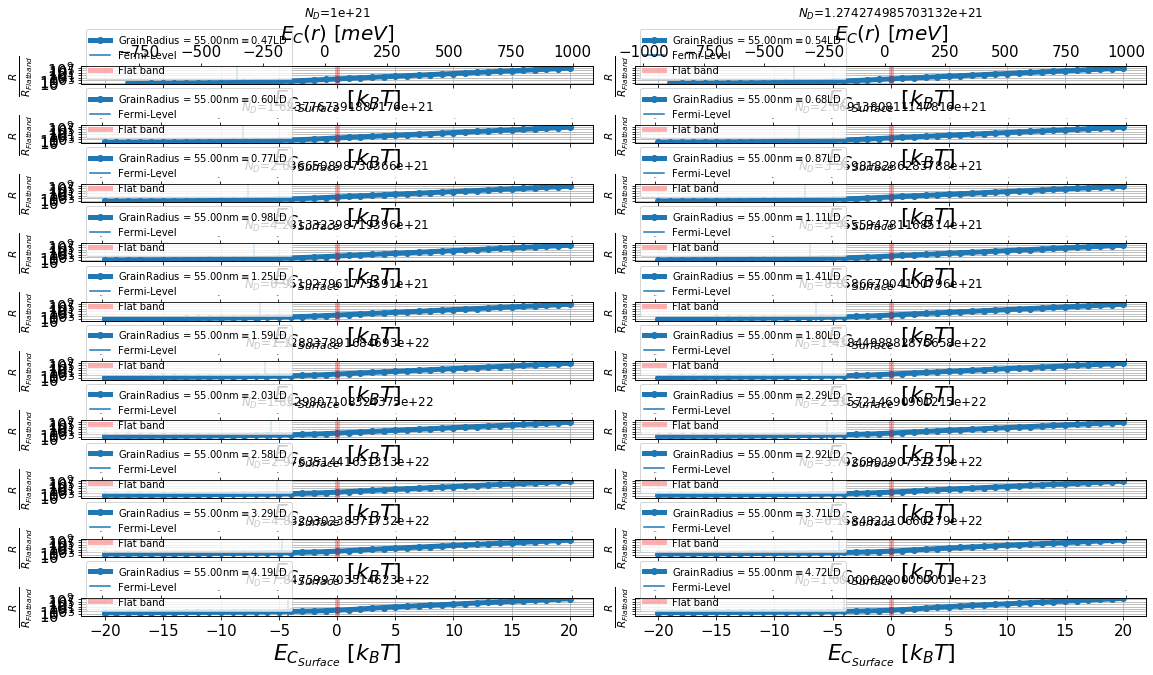

In [38]:

fig, axes = subplots(len(calc_dF_sol['ND'].unique())//2,2,figsize = (16,9), sharey=True, sharex=True)

for ax_i,(ND,calc_dF_n) in enumerate(calc_dF_sol.groupby('ND')):
    
    axe = fig.axes[ax_i]
    axe.set_title(f'$N_D$='+f'{ND}')
    
    axe_up = axe.twiny()
    
    for R,calc_dF_grainsize in calc_dF_n.groupby('R'):
        
        grain = create_grain_from_data(calc_dF_grainsize.iloc[0])
        
        #s = calc_dF_grainsize['d_v'].iloc[0].shape[0]
        
        flat_band = calc_dF_grainsize[calc_dF_grainsize['Einit_kT']==0].iloc[0]['rel_res_change']
        res = calc_dF_grainsize['rel_res_change']
        
        
        v = calc_dF_grainsize['Einit_kT']
        rel_size = grain.R/grain.material.LD
        
        axe.plot(v, res, 'o-', label = f'GrainRadius = {R*1e9:.2f}nm$\equiv${rel_size:.2f}LD', linewidth=5)
        #have a additional graph in units of meV on the x axis
        axe_up.plot(v*CONST.J_to_eV(grain.material.kT)*1000, res,alpha=0)
        
        
        axe.set_yscale('log')
        axe.set_ylabel(r'$\frac{R}{R_{Flatband}}$', fontsize =15)
        axe.set_xlabel('$E_{C_{Surface}}$ [$k_BT$]', fontsize =22)
        axe.tick_params(axis='both', which='major', labelsize=15)
        axe.grid(b=True)
        
       
    #draw the Fermi-Level
    axe.axvline(-grain.material.J_to_kT(grain.material.Diff_EF_EC), label='Fermi-Level')        
    axe.axvline(0, color = 'r', linewidth=5, alpha=0.3, label='Flat band')        
    
    if ax_i in [0,1]:
        axe_up.set_xlabel('$E_C(r)$ [$meV$]', fontsize =20)
        axe_up.tick_params(axis='both', which='major', labelsize=15)
    else:
        axe_up.tick_params(axis='both', which='major', labelsize=0)
        pass
        
        
    fig.tight_layout()
    axe.legend()



## Summary
Before using the new dataset to interpret experimental results, some interesting features can already be seen in the last figure.

### Fully depleted small grains:

For those grains, position of the conduction band at the surface $E_{C_{Surface}}$ is far away from the position of the Fermi energy $E_{Fermi}$ and the grain radius $Rad$ is small compared to the Debye length ($Rad<5*L_D$). In this case the resistance changes, due to the depletion layer controlled conduction, similar for all grains. This can be explained by the fact, that these grains are fully depleted. Without a separated depletion layer, possible volume effects of the different grain sizes do not exist.
For those small grains, the effect of the different grain size has an impact on the sensing properties only when the conduction band at the surface approaches the Fermi level. As seen in the last notebook, the dimensions of the accumulation layer are much smaller compared to the depletion layer. Therefore the grains are never getting "fully accumulated" and the grain size has again an influence on the transduction mechanism.

### Large grains:

For large grains ($Rad<5*L_D$), which are not fully depleted, two effects may overlay each other. First, the effect of a high resistive surface layer increases the resistance and second, the low resistive bulk area shrinks. Those two effects add up and increase in some cases the slope of the resistance change more than for fully depleted grains.
The small grains, which are fully depleted, do not show this effect.
Once the larger grains get full depleted, the volume effect of the surface layer is not present anymore and the change in resistance is comparable to one of smaller grains.

### Flat band situation:

Additionally it can be noticed, that the flat band situation may not be the situation, where the conduction mechanism starts to change. Rather the proximity to the Fermi level is responsible for altering the conduction mechanism.

## Conclusion
Real experimental data from simultaneous work function and resistance measurements can be fitted to this dataset. Since the detection of the grain size is rather simple, the fitting of the corresponding plots will reveal the corresponding Debye length and doping level $N_D$.
As additional feature for further understanding the surface reactions, the number of involved trapped charges at the surface can be extracted from the numerical model.
[Non-PDF readers, could use this link to guide them to the next notebook.](./4-Exp-data.ipynb)




# Bibliography section

%%latex
\bibliographystyle{alphadin}
\bibliography{ipython}

%%latex
\newpage
This page is intentionally left blank.